In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# %matplotlib ipympl

print_titles = False
save_figures = True

plt.rcParams.update({
    "axes.prop_cycle": plt.cycler(color=["black"] 
                            + plt.rcParams['axes.prop_cycle'].by_key()['color']),
    "font.family": "serif",             # Serif fonts (e.g., Times-like)
    "font.serif": ["Linux Libertine"],  # Same font as in LaTeX
    "font.size": 14,                    # Base font size
    "mathtext.fontset": "cm",           # Math Font to match a bit better
    "legend.fontsize": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,                  # High resolution
    "savefig.dpi": 300,
    "axes.linewidth": 0.8,              # Thin axis lines
    "xtick.direction": "in",            # Ticks pointing inward
    "ytick.direction": "in",
    "xtick.top": True,                  # Ticks on all sides
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "grid.linewidth": 0.4
})

fsize_small = (4,2.75) # for a single colum in double colum
fsize_large = (6.5,4)

## (i) - (ii)
Loading the data:

In [3]:
def load_dat(filename):
    data_path = os.path.join("data", filename)
    return pd.read_csv(data_path, 
                       delimiter=r'\s+',
                       header=None,
                       usecols=[2,5,7],
                       names=['t_lb','V_m/V_v','MAR']
                       )

masses = [10.0,10.5,11.0,11.5,12.0,12.5,13.5]
data = {}
for i, fname in enumerate(os.listdir('data')):
    path = os.path.join('data', fname)
    data[masses[i]] = load_dat(fname)

data[10].head()

,t_lb,V_m/V_v,MAR
0,0.0015,0.12801,0.26892
1,0.1269,0.12806,0.18649
2,0.2519,0.12809,0.19827
3,0.3763,0.12812,0.20586
4,0.5002,0.12814,0.21330


Converting the look-back time to cosmic

In [4]:
for mass, df in data.items():
    df['t_c'] = 13.8 - df['t_lb'] 

data[10].head()

,t_lb,V_m/V_v,MAR,t_c
0,0.0015,0.12801,0.26892,13.7985
1,0.1269,0.12806,0.18649,13.6731
2,0.2519,0.12809,0.19827,13.5481
3,0.3763,0.12812,0.20586,13.4237
4,0.5002,0.12814,0.21330,13.2998


Now the interpolation plot:

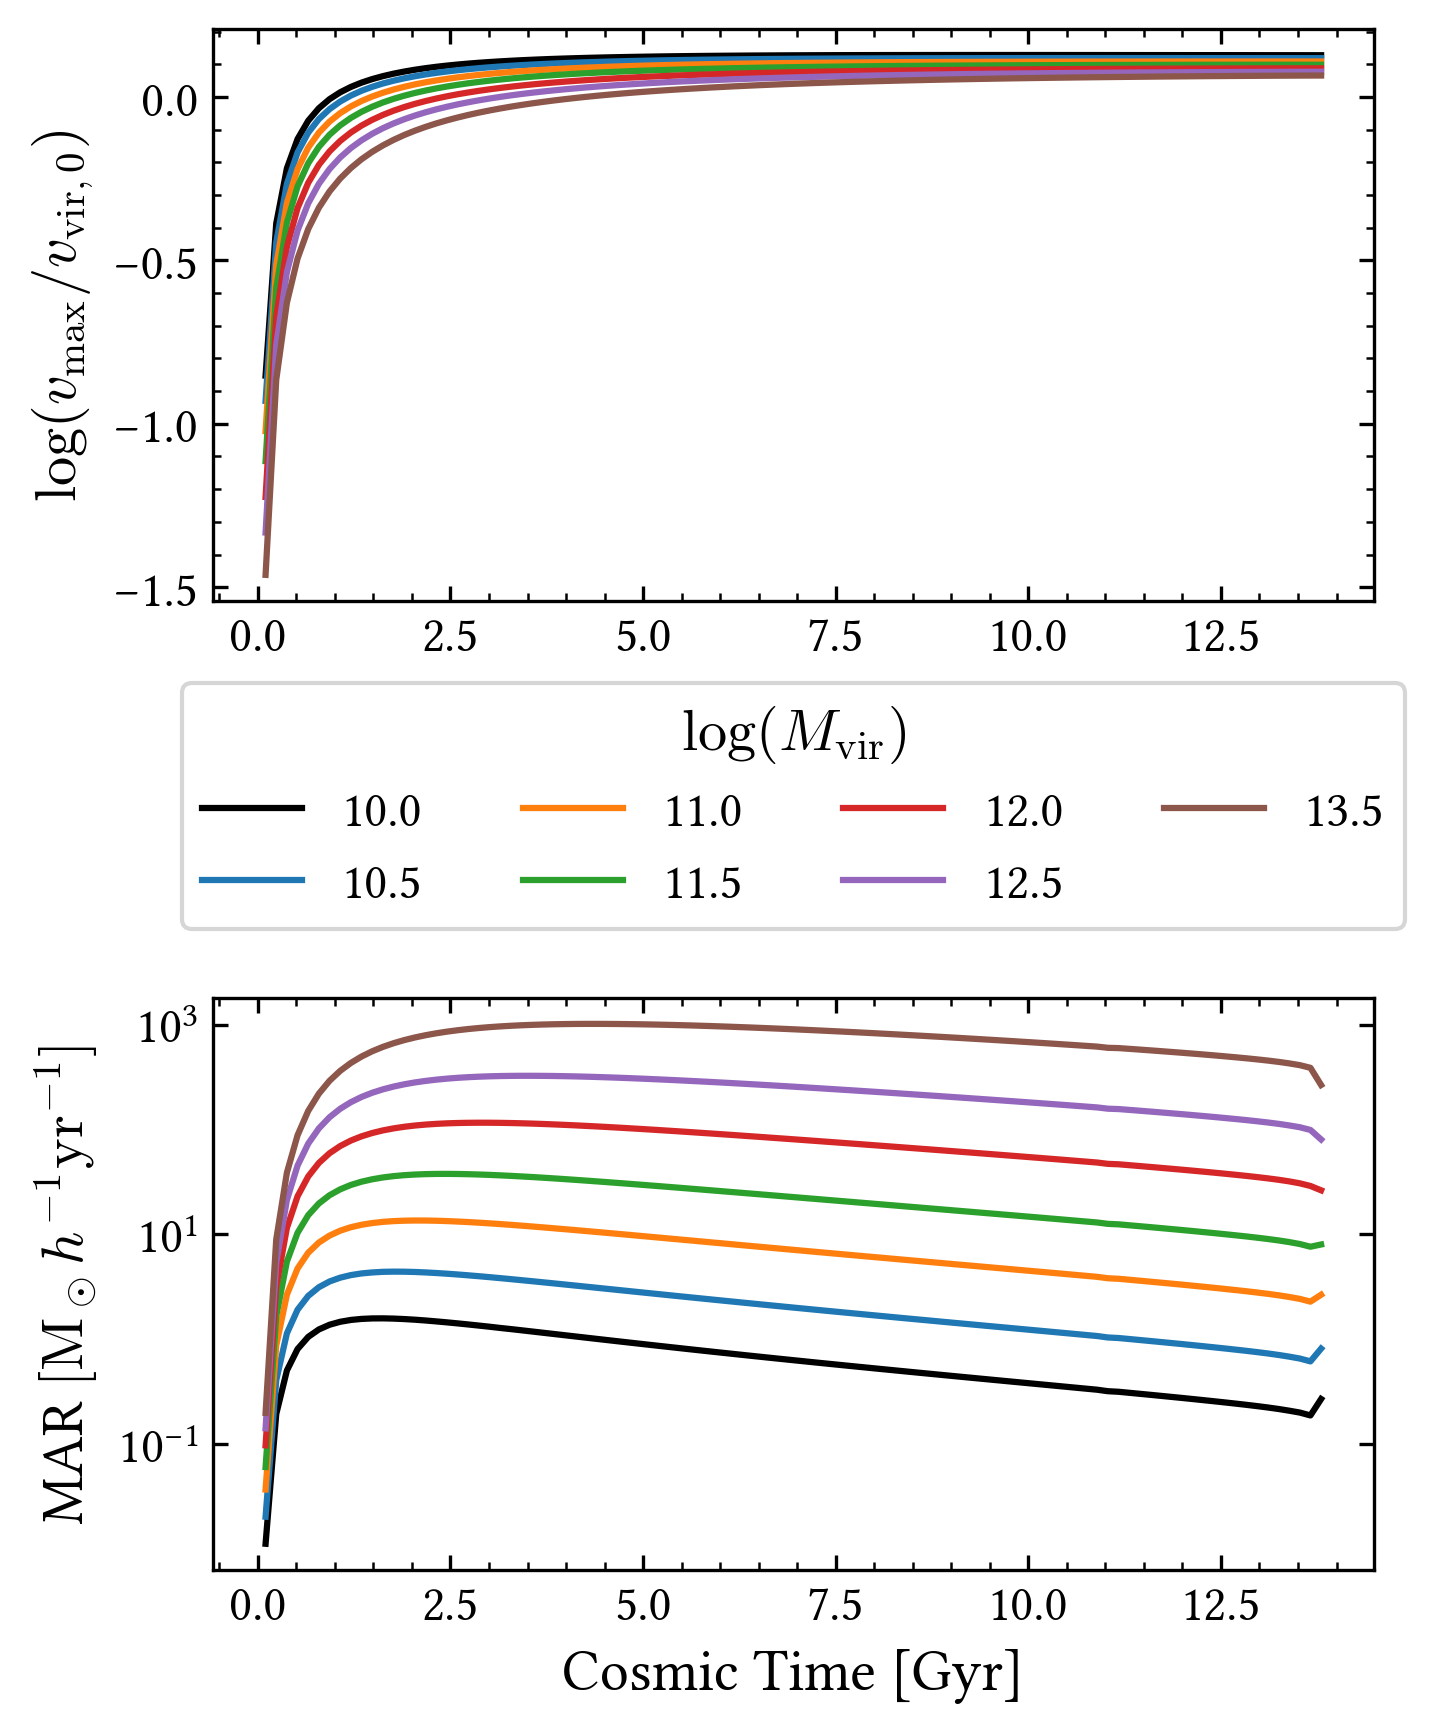

In [7]:
t_space = np.linspace(0.1,13.8,100)

fig, ax = plt.subplots(2,sharex=True,figsize = (5,6))
if print_titles: fig.suptitle(r"$v_{\text{max}}$ and the Dark Matter Mass Acretion")
ax[0].set_ylabel(r'$\log(v_{\text{max}}/v_{\text{vir},0})$')
ax[1].set_ylabel(r'MAR $[\text{M}_\odot h^{-1} \text{yr}^{-1}]$')
ax[1].set_xlabel('Cosmic Time [Gyr]')
if print_titles: fig.supxlabel('Cosmic Time [Gyr]')

for mass, df in data.items():
    y_v = np.interp(t_space,df['t_c'][::-1],df['V_m/V_v'][::-1])
    y_MAR = np.interp(t_space,df['t_c'][::-1],df['MAR'][::-1])
    ax[0].plot(t_space,y_v,label=f'{mass}')
    ax[1].plot(t_space,y_MAR,label=f'{mass}')

ax[0].tick_params(labelbottom=True)
ax[0].legend(
    title=r'$\log(M_{\text{vir}})$',
    ncol=4,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1)  # move below first plot
)
# ax[1].legend(title=r'$\log(M_{\text{vir}})$',ncol=4)
ax[1].set_yscale('log')
plt.tight_layout()

if save_figures: plt.savefig('plots/v_and_mar-t.pdf')
plt.show()
plt.close()

## (iii - v)
We will use eulers methods to solve the different time evolutions. Our rough sketch:

```python
# Initialize
M_dm, M_g, M_star, SFR, dM_g = zeroes
dM_dm = interp(data) 

# Start values
SFR[0] = A * M_g
dM_g[0] = gamma(0) * f_b * dM_dm[0] - (1-R) * SFR # Assuming here that gas outflow = 0

for i,t enumerate t_space:
    M_dm[i+1] = M_dm[0] + dM_dm[0]
    M_star[i+1] = M_star[i] + (1-R) * SFR[i] * dt
    M_g[i+1] = M_g[i] + dM_gas * dt

    SFR[i+1] = A * M_g[i+1]
    dM_g[i+1] = gamma(M_dm[i+1]) * f_b * dM_dm[i+1]

```
    For initial values at $t_c = 0$ we will assume 0 for each mass (DM, gas and stellar).

In [6]:
def gamma(M_dm):
    M_crit = 6e11 # Critical Mass [Solar Masses]
    if M_dm > M_crit:
        return 0.3
    else:
        return 1

def mass_evolution(M_vir, df, f_b=0.18, stellar_frac=0.09, n_steps=100):
    ''' 
    Models the backwards evolution of the different masses

    INPUT
    -----
    M_vir : (float)
        Log_10 of the virial mass of the galaxy
    df : (pd.DataFrame)
        Dataframe with columns ['t_c','MAR']
    f_b : (float)
        Fraction of baryonic matter
    stellar_frac : (float)
        Fraction of stelar mass from total matter
    n_steps : int
        Number of time steps for the evolution

    OUTPUT
    -----
    t_reverse, M_dm, M_g, M_star, SFR : np.ndarray
        the results

    '''

    R = 0.4
    A = 2e-10

    # Initialize
    t_cosmic = np.linspace(0.1,13.8,n_steps) # equidistant cosmic time in Gyr
    dt = 13.8 / n_steps * 1e9 # in yr

    dM_dm = np.interp(t_cosmic,df['t_c'][::-1],df['MAR'][::-1]) # Not sure if this h is correct ???

    M_dm, M_g, M_star, SFR, dM_g = np.zeros((5,n_steps))

    # Initial Values at t=t_0
    
    # M_dm[0], M_g[0], M_star[0] = get_initial_mass(M_vir, df, f_b, stellar_frac)
    SFR[0] = A * M_g[0]
    dM_g[0] = gamma(M_dm[0]) * f_b * dM_dm[0] - (1-R) * SFR[0] # Assuming here that gas outflow = 0

    for i in range(n_steps-1):

        M_dm[i+1] = M_dm[i] + dM_dm[i] * dt
        M_star[i+1] = M_star[i] + (1-R) * SFR[i] * dt 
        M_g[i+1] = M_g[i] + dM_g[i] * dt

        SFR[i+1] = A * M_g[i+1]
        dM_g[i+1] = gamma(M_dm[i+1]) * f_b * dM_dm[i+1] - (1 - R)*SFR[i+1]
    
    # return t_cosmic, M_dm, M_g, M_star, SFR
    return t_cosmic, M_dm, M_g, M_star, SFR


# dm, gas, stellar = get_initial_mass(10.0,data[10])
# print(0.82 * 10**10 - dm)
# print(gas, stellar)

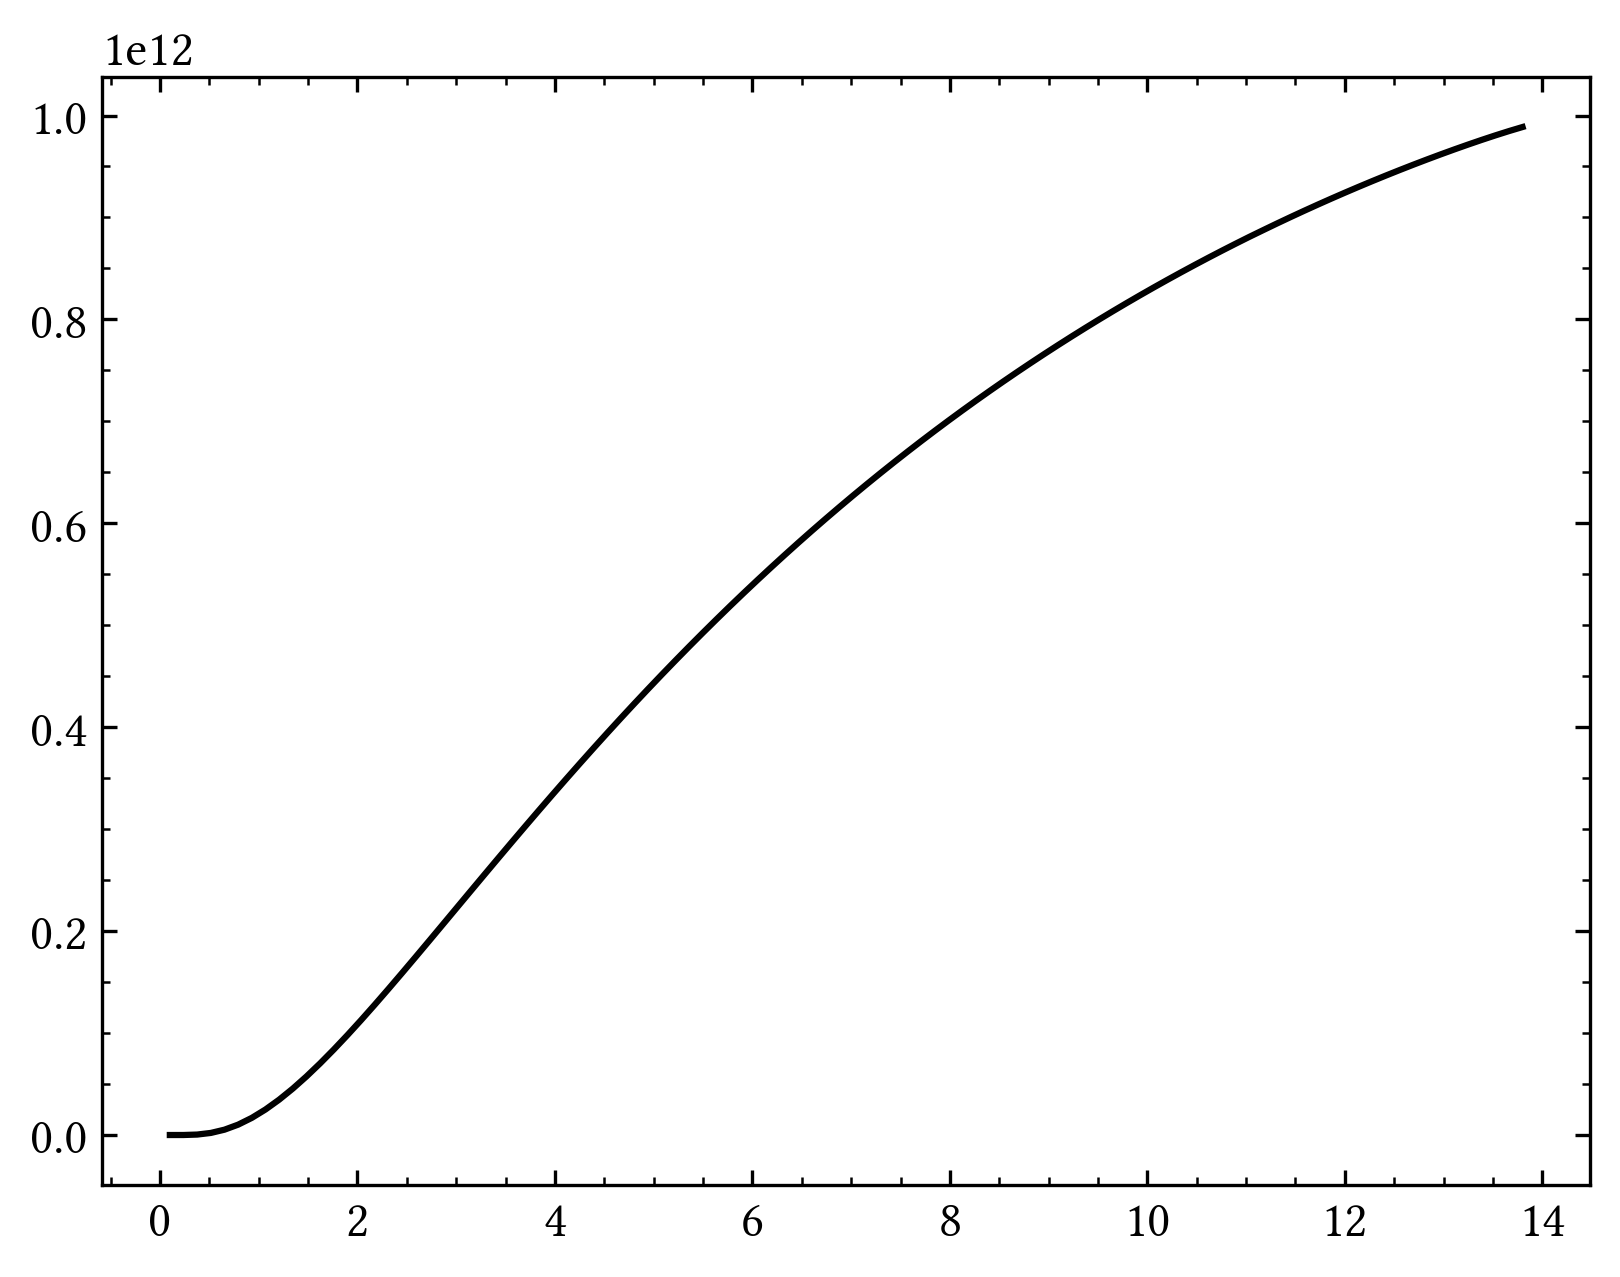

In [7]:
# Just a little test
t, M_dm, M_g, M_star, SFR = mass_evolution(12.0,data[12.0])

plt.plot(t,M_dm)

Now we plot the stellar mass to dark matter mass ratio with the results of our simple model.

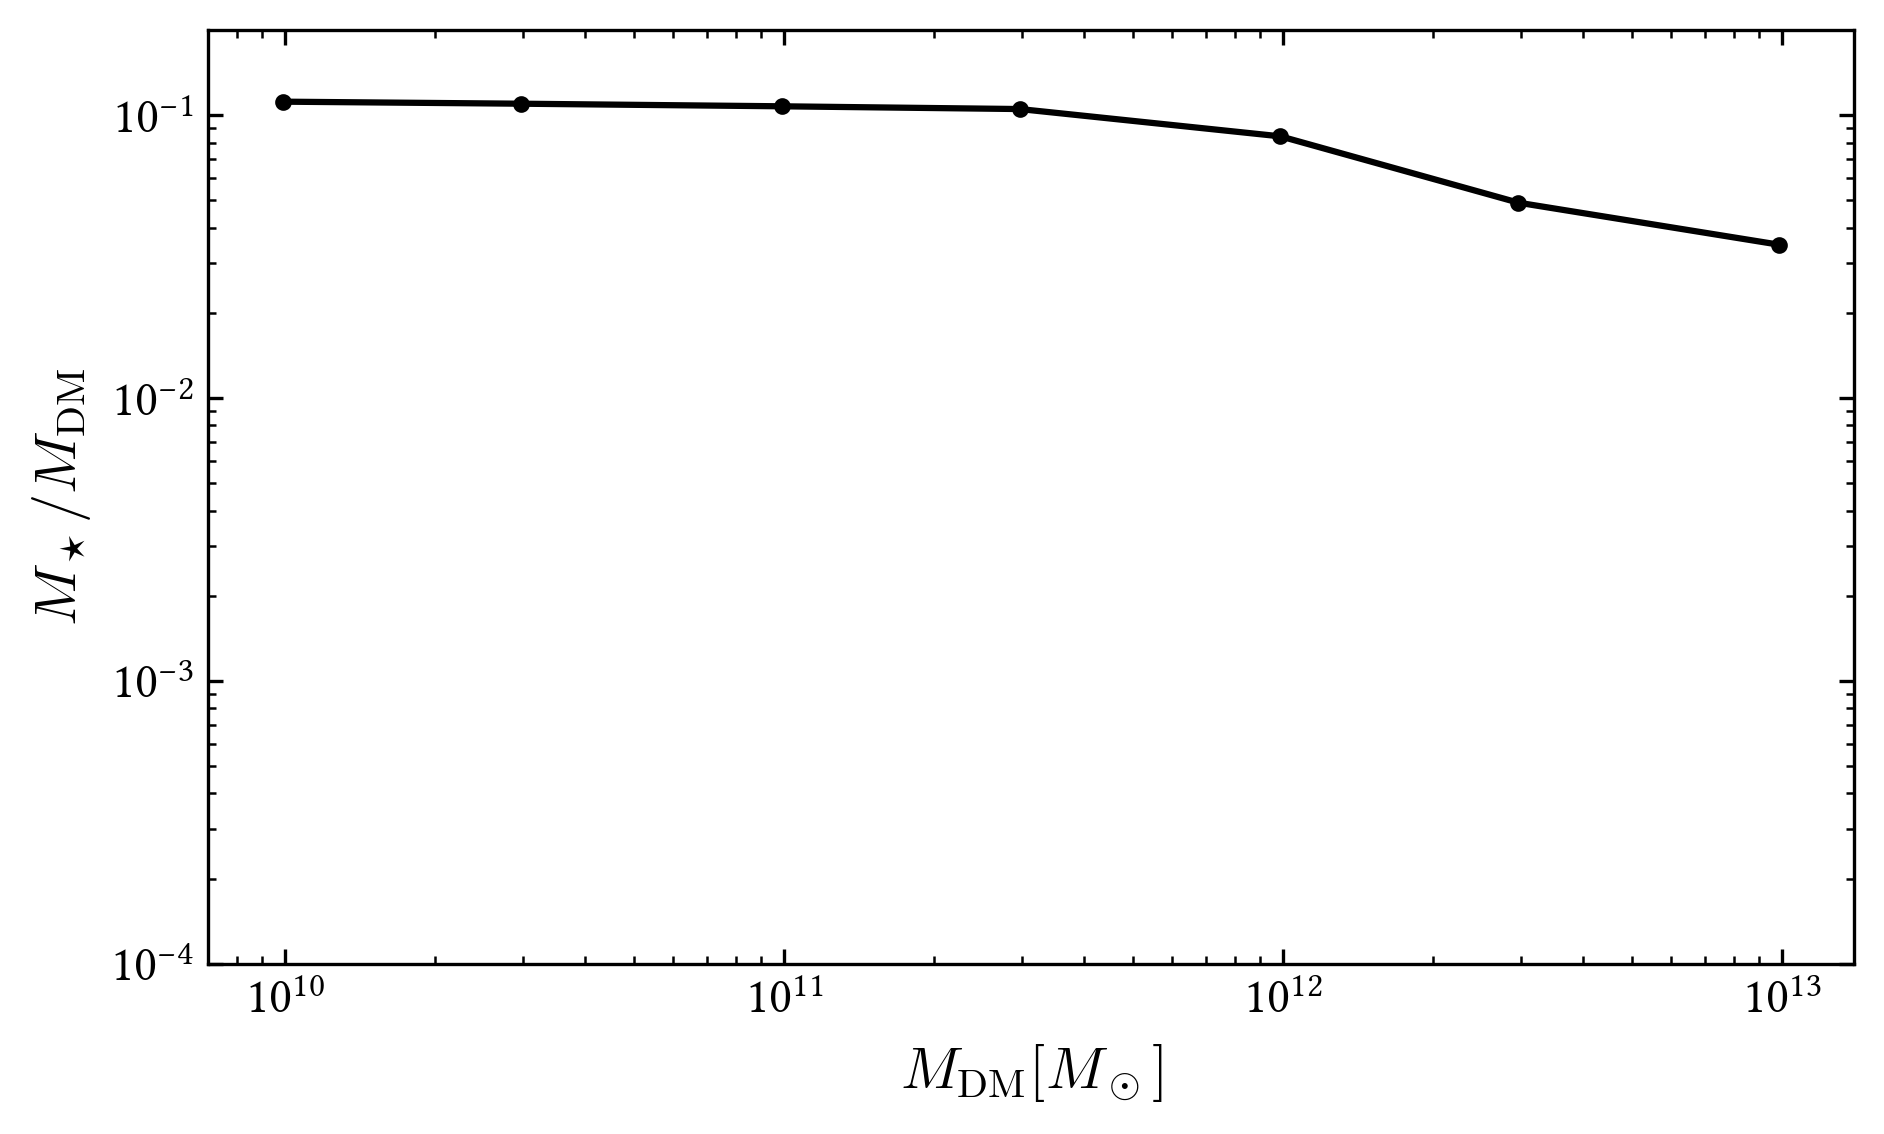

In [8]:

M_star_list = []
M_dm_list = []

for M_vir, df in data.items():
    _, M_dm, _, M_star, _ = mass_evolution(M_vir, df)
    M_star_list.append(M_star[-1])
    M_dm_list.append(M_dm[-1])

ratio = np.array(M_star_list)/np.array(M_dm_list)

fig, ax = plt.subplots(figsize = fsize_large)
if print_titles: fig.suptitle(r'Stellar Mass to Dark Matter Ratio at $z=0$ (Simple)')
ax.loglog(M_dm_list, ratio, marker='.')
ax.set_xlabel(r'$M_{\text{DM}} [M_\odot]$')
ax.set_ylabel(r'$M_\star / M_{\text{DM}}$')
ax.set_ybound(1e-4,0.2)
plt.tight_layout()

if save_figures: plt.savefig('plots/SM-DM_simple.pdf')
plt.show()
plt.close()

## (vi) - (vii)

Now we are adding stellar feedback.

In [9]:
def mass_evolution_v2(M_vir, df, alpha=0.2, beta=0.2, f_b=0.18, stellar_frac=0.09, n_steps=100):
    ''' 
    Models the backwards evolution of the different masses

    INPUT
    -----
    M_vir : (float)
        Log_10 of the virial mass of the galaxy
    df : (pd.DataFrame)
        Dataframe with columns ['t_c','MAR']
    alpha, beta : (float)
        Parameters of the stellar feedback
    f_b : (float)
        Fraction of baryonic matter
    stellar_frac : (float)
        Fraction of stelar mass from total matter
    n_steps : (int)
        Number of time steps for the evolution

    OUTPUT
    -----
    t_reverse, M_dm, M_g, M_star, SFR : (np.ndarray)
        the results

    '''

    R = 0.4
    A = 2e-10
    M_crit = 6e11 # [Solar Masses]

    # Initialize
    t_cosmic = np.linspace(0.1,13.8,n_steps) # equidistant cosmic time in Gyr
    dt = 13.8 / n_steps * 1e9 # in yr

    dM_dm = np.interp(t_cosmic,df['t_c'][::-1],df['MAR'][::-1]) 

    M_dm, M_g, M_star, SFR, dM_g = np.zeros((5,n_steps))

    # Initial Values at t=t_0
    
    # M_dm[0], M_g[0], M_star[0] = get_initial_mass(M_vir, df, f_b, stellar_frac)
    SFR[0] = A * M_g[0]
    # dM_g[0] = gamma(M_dm[0]) * f_b * dM_dm[0] - (1 - R + beta * (M_dm[0]/M_crit)**(-alpha))*SFR[0]
    dM_g[0] = gamma(M_dm[0]) * f_b * dM_dm[0] - (1-R) * SFR[0] # ONLY for t=0, assuming here that gas outflow = 0 
    for i in range(n_steps-1):

        M_dm[i+1] = M_dm[i] + dM_dm[i] * dt
        M_star[i+1] = M_star[i] + (1-R) * SFR[i] * dt 
        M_g[i+1] = M_g[i] + dM_g[i] * dt
        if M_g[i+1] < 0: M_g[i+1] = 0 # Check for unrealistic results

        SFR[i+1] = A * M_g[i+1]
        dM_g[i+1] = gamma(M_dm[i+1]) * f_b * dM_dm[i+1] - (1 - R + beta * (M_dm[i+1]/M_crit)**(-alpha))*SFR[i+1]
    
    # return t_cosmic, M_dm, M_g, M_star, SFR
    return t_cosmic, M_dm, M_g, M_star, SFR

We will try to find the optimal alpha and beta values by visually comparing to the literature plots.

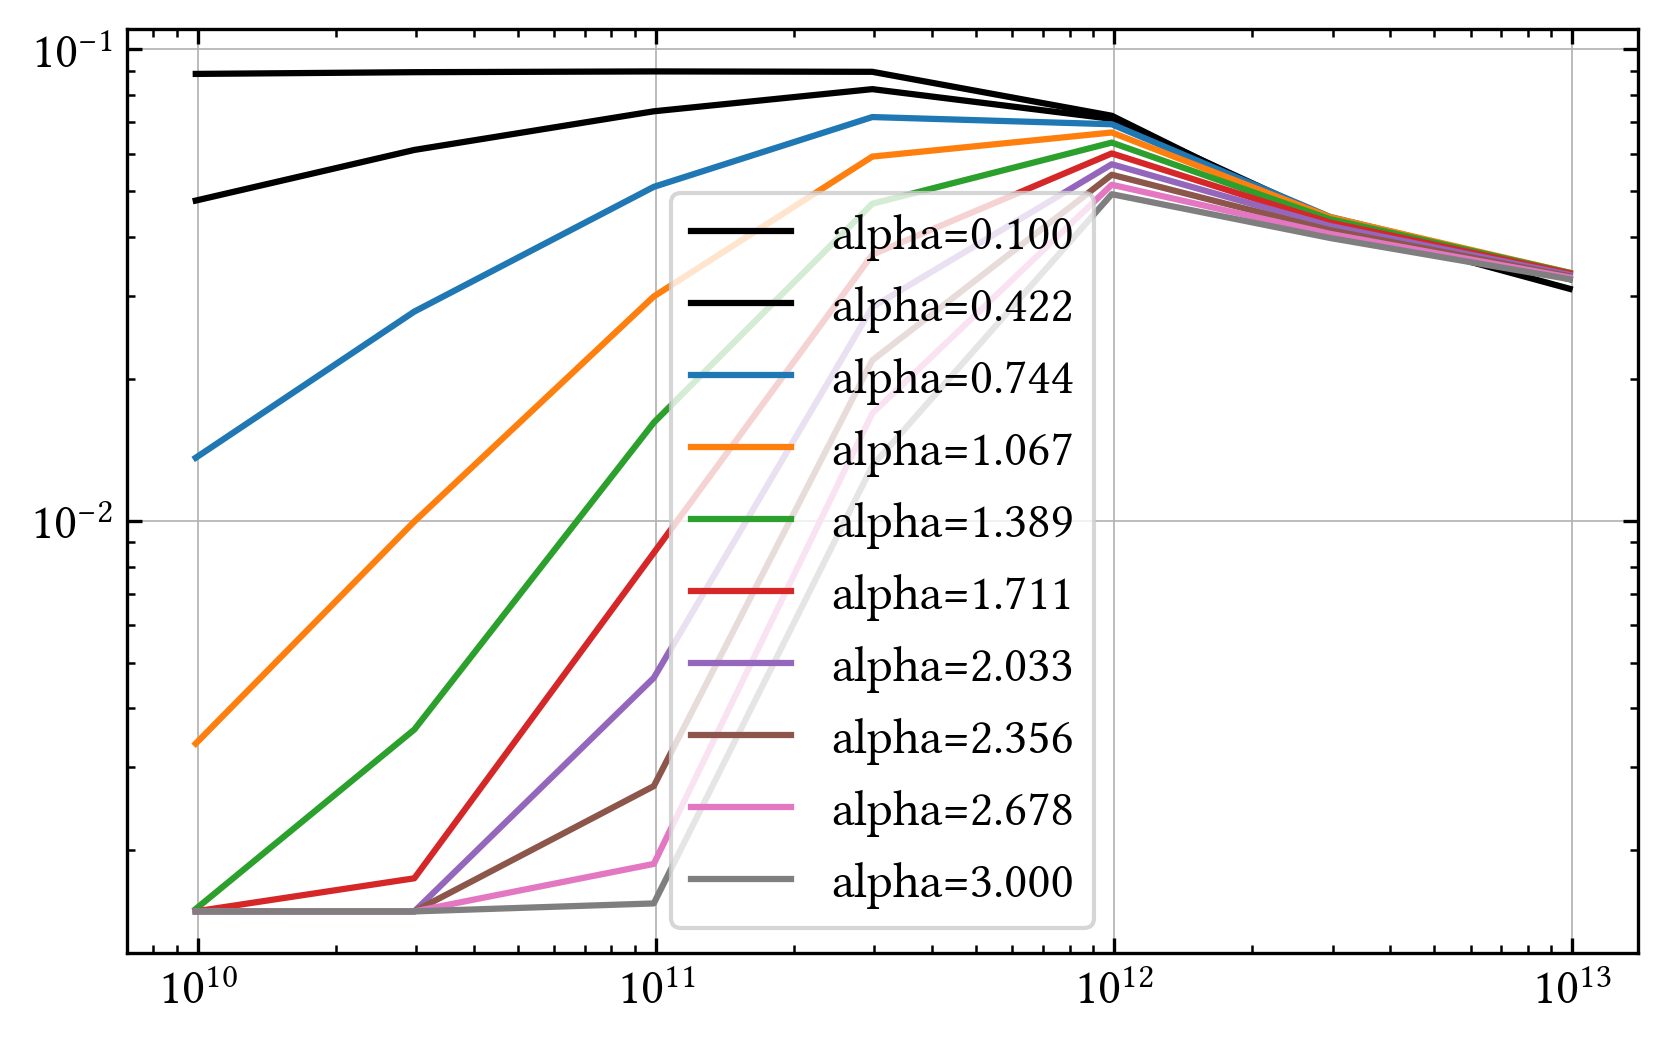

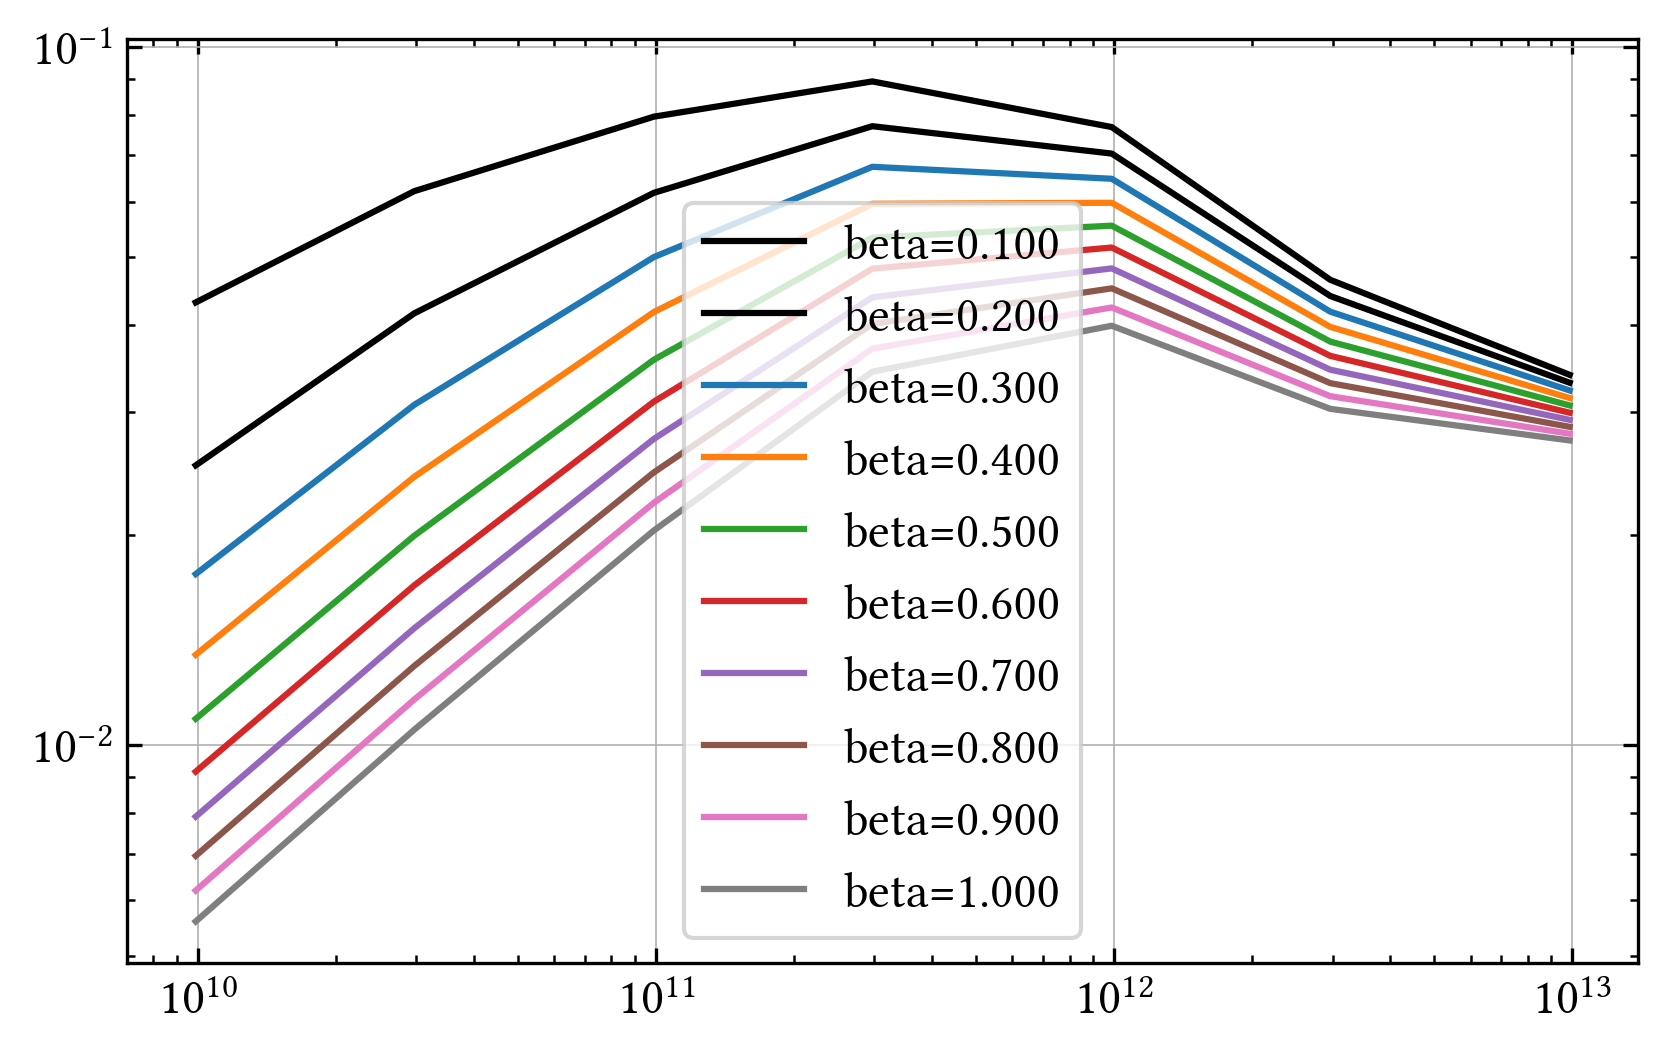

In [10]:
alpha_space = np.linspace(0.1,3,10) # Values above 3 are too far away

fig,ax = plt.subplots(figsize = fsize_large)

for alpha in alpha_space:
    M_star_list = []
    M_dm_list = []

    for M_vir, df in data.items():
        _, M_dm, _, M_star, _ = mass_evolution_v2(M_vir, df, alpha=alpha)
        M_star_list.append(M_star[-1])
        M_dm_list.append(M_dm[-1])

    ratio = np.array(M_star_list)/np.array(M_dm_list)
    if ratio[0] <= 1: ax.loglog(M_dm_list, ratio, label=f"alpha={alpha:.3f}")
ax.legend()
ax.grid()
plt.show()
plt.close()

alpha_best = 0.6

beta_space = np.linspace(0.1,1,10)
fig,ax = plt.subplots(figsize = fsize_large)

for beta in beta_space:
    M_star_list = []
    M_dm_list = []

    for M_vir, df in data.items():
        _, M_dm, _, M_star, _ = mass_evolution_v2(M_vir, df, alpha=alpha_best, beta=beta)
        M_star_list.append(M_star[-1])
        M_dm_list.append(M_dm[-1])

    ratio = np.array(M_star_list)/np.array(M_dm_list)
    if ratio[0] <= 1: ax.loglog(M_dm_list, ratio, label=f"beta={beta:.3f}")
ax.legend()
ax.grid()
plt.show()
plt.close()


        

With these best $\alpha$ and $\beta$ values we will do several plots. First we will do the simulation and then do the plots based on the results in the next few cells.

In [11]:
# Get the data
alpha_best = 0.61
beta_best = 1

M_dm_list = []
SM_list = []
SFR_list = []
M_g_list = []

for M_vir, df in data.items():
    _, M_dm, M_g, M_star, SFR = mass_evolution_v2(M_vir, df, alpha=alpha_best, beta=beta)
    M_dm_list.append(M_dm[-1])
    M_g_list.append(M_g[-1])
    SM_list.append(M_star[-1])
    SFR_list.append(SFR[-1])
    
M_dm_list = np.array(M_dm_list)
M_g_list = np.array(M_g_list)
SM_list = np.array(SM_list)
SFR_list = np.array(SFR_list)


alpha = 0.61 | beta = 1


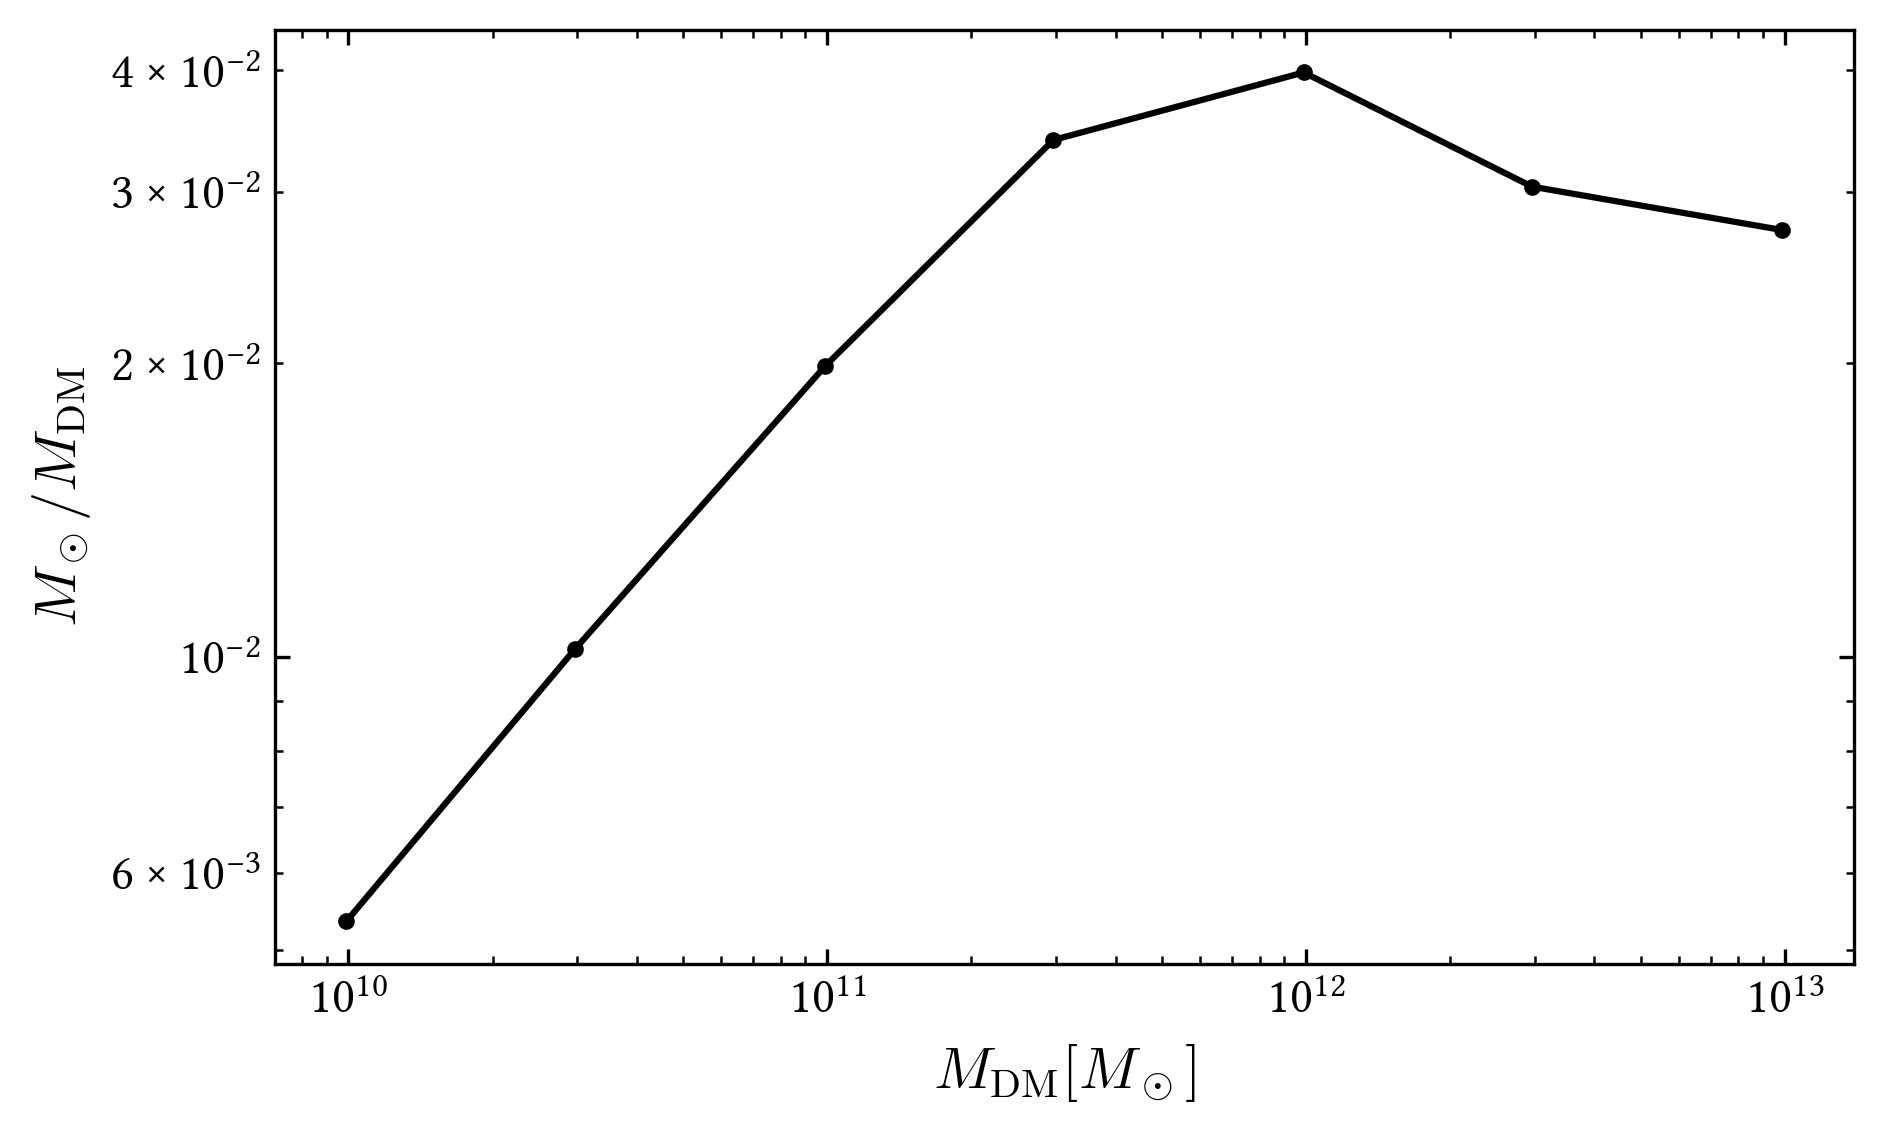

In [12]:
# First Plot
ratio = SM_list/M_dm_list

fig, ax = plt.subplots(figsize=fsize_large)
if print_titles: fig.suptitle(r'Stellar Mass to Dark Matter Ratio at $z=0$')

ax.loglog(M_dm_list, ratio, marker='.')
ax.set_xlabel(r'$M_{\text{DM}} [M_\odot]$')
ax.set_ylabel(r'$M_\odot / M_{\text{DM}}$')
plt.tight_layout()

if save_figures: plt.savefig('plots/SM-DM_opt.pdf')
print(f'alpha = {alpha_best} | beta = {beta_best}')
plt.show()
plt.close()

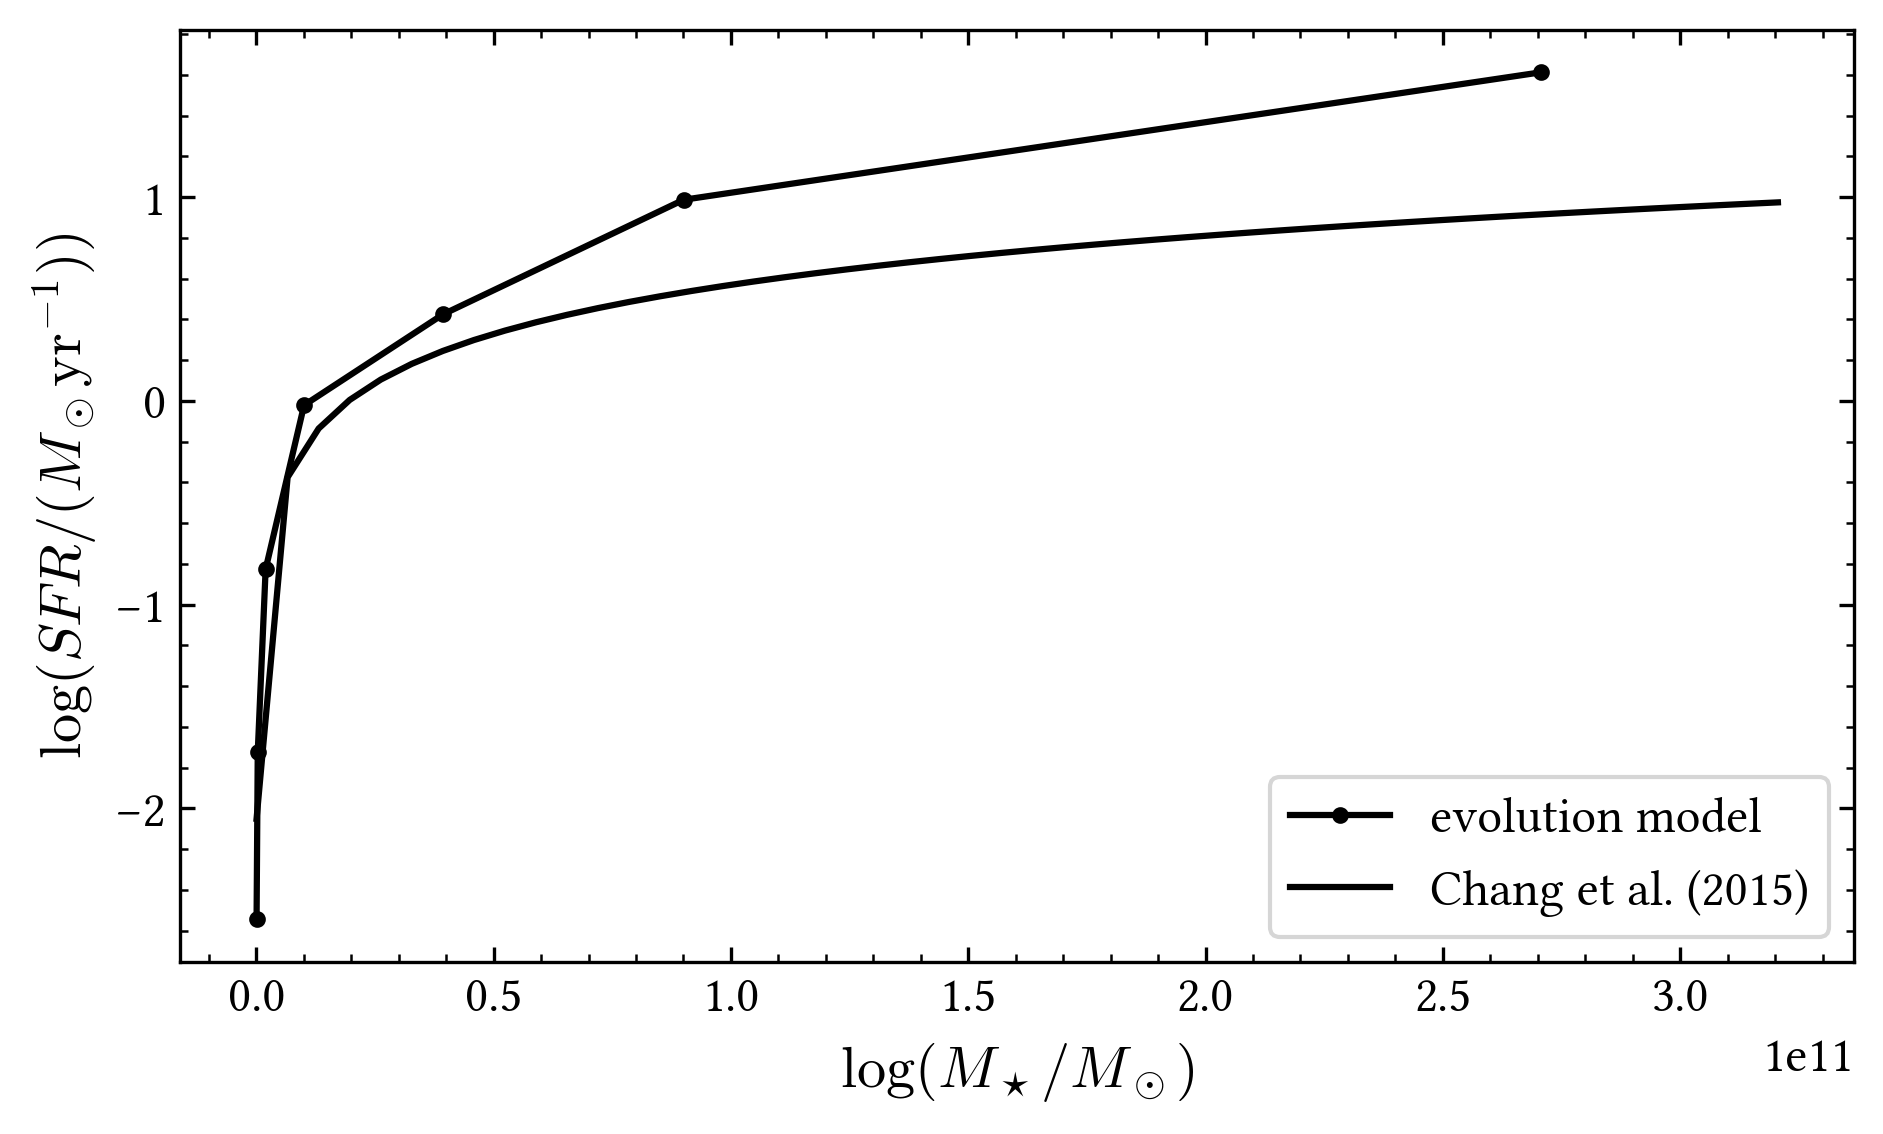

In [13]:
# SFR over SM Plot

def sfr_chang(M_s):
    return 0.8*np.log10(M_s/(10**10)) - 0.23

SM_range = np.linspace(SM_list[0], SM_list[-1]+5e10)
results_chang = sfr_chang(SM_range)

fig, ax = plt.subplots(figsize=fsize_large)
if print_titles: fig.suptitle(r'Star Formation Rate Comparison at $z=0$')

ax.plot(SM_list,np.log10(SFR_list),marker='.', label='evolution model')
ax.plot(SM_range, results_chang, label='Chang et al. (2015)')

ax.set_xlabel(r'$\log(M_\star / M_\odot)$')
ax.set_ylabel(r'$\log(SFR / (M_\odot \text{yr}^{-1}))$')
plt.legend()
plt.tight_layout()

if save_figures: plt.savefig('plots/SFR_comparison.pdf')
plt.show()

## (viii)

Comparison to the baryonic Tully-Fisher relation.

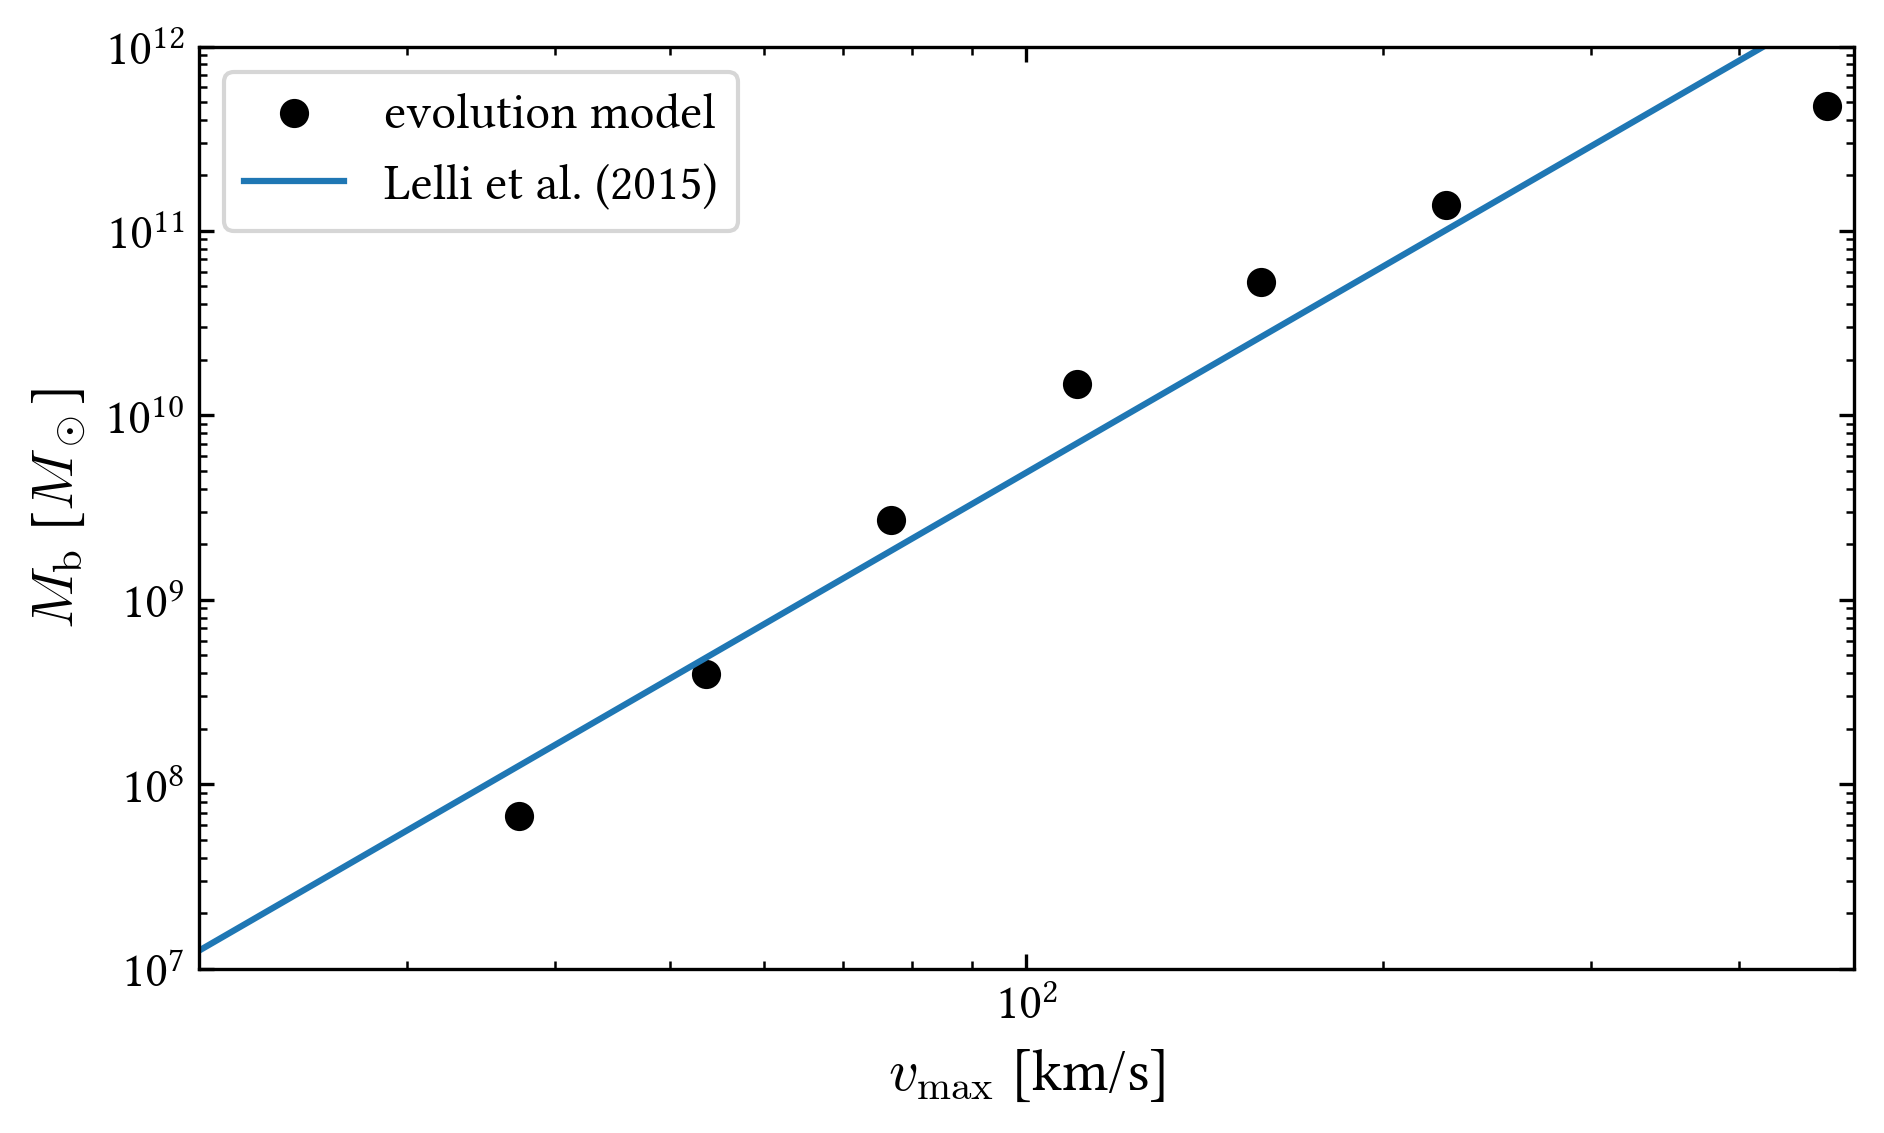

In [14]:
def fb_lelli(v_max):
    return 10**(3.71*np.log10(v_max)+2.27)

G = 6.674e-11 # m^3/(kg s^2)
C = 101 # Triangle c from the book at z=0
H = 70 * 3.24e-20

def get_v_max(M_vir):
    # Units: M_vir to kg and H Mpc to km
    return (G * M_vir * 1.989*10**30 * H)**(1/3) * (0.5*C)**(1/6)

v_max_list = [] # at z=0

for M_vir, df in data.items():
    M_vir = 10**M_vir
    v_ratio = 10**(df['V_m/V_v'][0])
    v_vir = ()
    v_max = v_ratio * get_v_max(M_vir)
    v_max_list.append(v_max)

v_max_list = np.array(v_max_list)

# Conver to km/s
v_max_list = v_max_list / 1000

M_b_list = SM_list + M_g_list 

x_min = 20
x_max = 500
v_max_range = np.linspace(x_min, x_max, 100)

fig, ax = plt.subplots(figsize=fsize_large)
if print_titles: fig.suptitle('Baryonic Mass over Max. Circular Speed')

ax.scatter(v_max_list,M_b_list, label='evolution model')
ax.plot(v_max_range, fb_lelli(v_max_range), label='Lelli et al. (2015)', color='tab:blue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$v_{\text{max}}$ [km/s]')
ax.set_ylabel(r'$M_{\text{b}}$ [$M_\odot$]')
ax.set_ylim(10**7,10**12)
ax.set_xlim(x_min,x_max)
ax.legend()
plt.tight_layout()

if save_figures: plt.savefig('plots/fb-vmax.pdf')
plt.show()
plt.close()

del M_b_list

In this case it is easier to find the optimal $\alpha$ and $\beta$ value mathematically, by doing a log-$\chi^2$ square test.

In [15]:
# Chi square test

lelli_values = fb_lelli(v_max_list)

alpha_best_lelli = 0
beta_best_lelli = 0
min_chi2 = 1e15

for alpha in np.linspace(0.1,5,100):

    for beta in np.linspace(0.01,1,100):
        M_dm_list = []
        SM_list = []
        SFR_list = []
        M_g_list = []

        for M_vir, df in data.items():
            _, M_dm, M_g, M_star, SFR = mass_evolution_v2(M_vir, df, alpha=alpha, beta=beta)
            M_dm_list.append(M_dm[-1])
            M_g_list.append(M_g[-1])
            SM_list.append(M_star[-1])
            SFR_list.append(SFR[-1])
        
        M_dm_list = np.array(M_dm_list)
        M_g_list = np.array(M_g_list)
        SM_list = np.array(SM_list)
        SFR_list = np.array(SFR_list)
        
        M_b_list = SM_list + M_g_list 

        sum = np.sum((np.log10(M_b_list) - np.log10(lelli_values))**2 / np.log10(lelli_values))
        
        if sum < min_chi2:
            min_chi2 = sum
            alpha_best_lelli = alpha
            beta_best_lelli = beta

        del M_b_list
        
print(f'Best Fit for Lelli et al. (2015): alpha = {alpha_best_lelli} | beta = {beta_best_lelli} | chi^2 = {min_chi2}')


Best Fit for Lelli et al. (2015): alpha = 0.5454545454545455 | beta = 1.0 | chi^2 = 0.05413049711998082


Now we plot using these values.

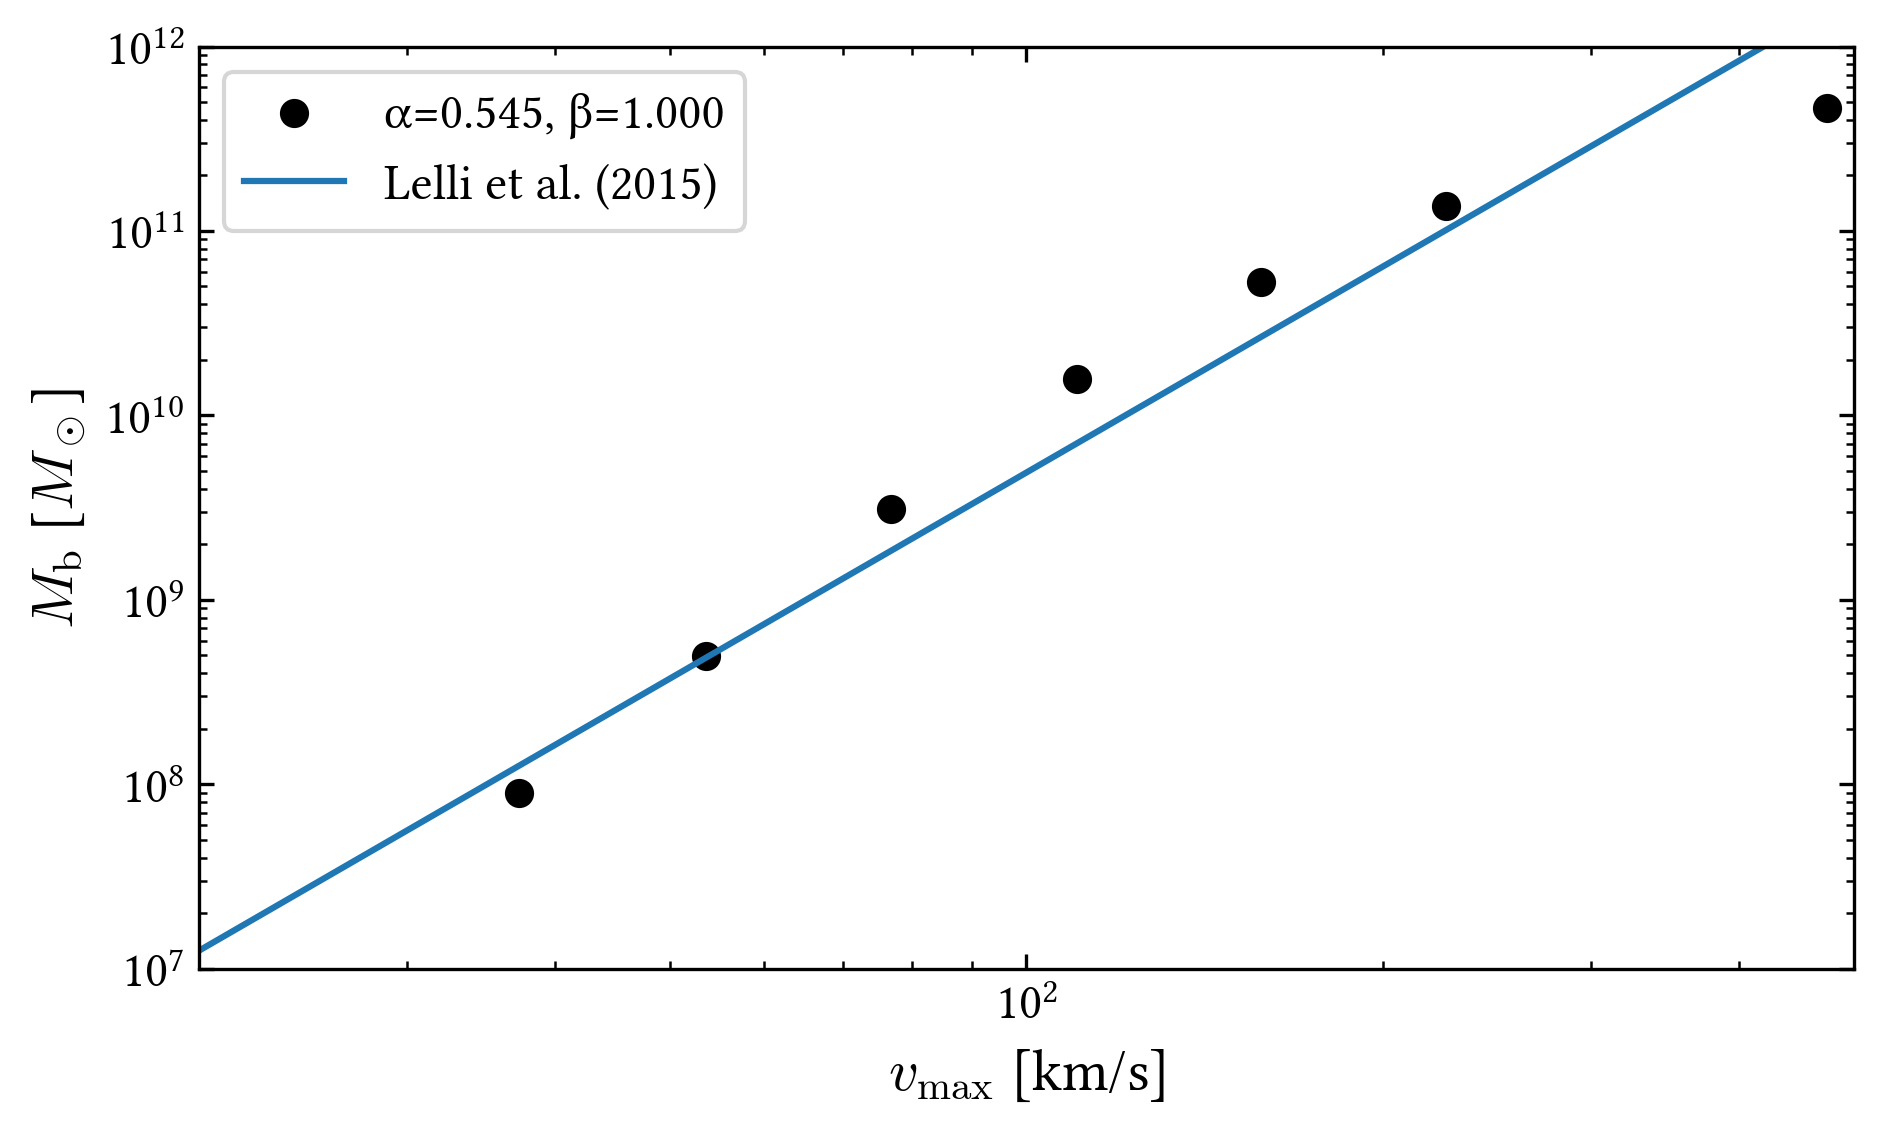

In [16]:
M_dm_list = []
SM_list = []
SFR_list = []
M_g_list = []

for M_vir, df in data.items():
            _, M_dm, M_g, M_star, SFR = mass_evolution_v2(M_vir, df, alpha=alpha_best_lelli, beta=beta_best_lelli)
            M_dm_list.append(M_dm[-1])
            M_g_list.append(M_g[-1])
            SM_list.append(M_star[-1])
            SFR_list.append(SFR[-1])

M_dm_list = np.array(M_dm_list)
M_g_list = np.array(M_g_list)
SM_list = np.array(SM_list)
SFR_list = np.array(SFR_list)

M_b_list = SM_list + M_g_list 

fig, ax = plt.subplots(figsize=fsize_large)
if print_titles: fig.suptitle('Baryonic Mass over Max. Circular Speed (optimized)')

ax.scatter(v_max_list,M_b_list, label=f'α={alpha_best_lelli:.3f}, β={beta_best_lelli:.3f}')
ax.plot(v_max_range, fb_lelli(v_max_range), label='Lelli et al. (2015)', color='tab:blue')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$v_{\text{max}}$ [km/s]')
ax.set_ylabel(r'$M_{\text{b}}$ [$M_\odot$]')
ax.set_ylim(10**7,10**12)
ax.set_xlim(x_min,x_max)
ax.legend()
plt.tight_layout()

if save_figures: plt.savefig('plots/fb-vmax_chi.pdf')
plt.show()
plt.close()

Let's check the plots from before with these optimized values, since these are now based on actual math and not visual comparison.

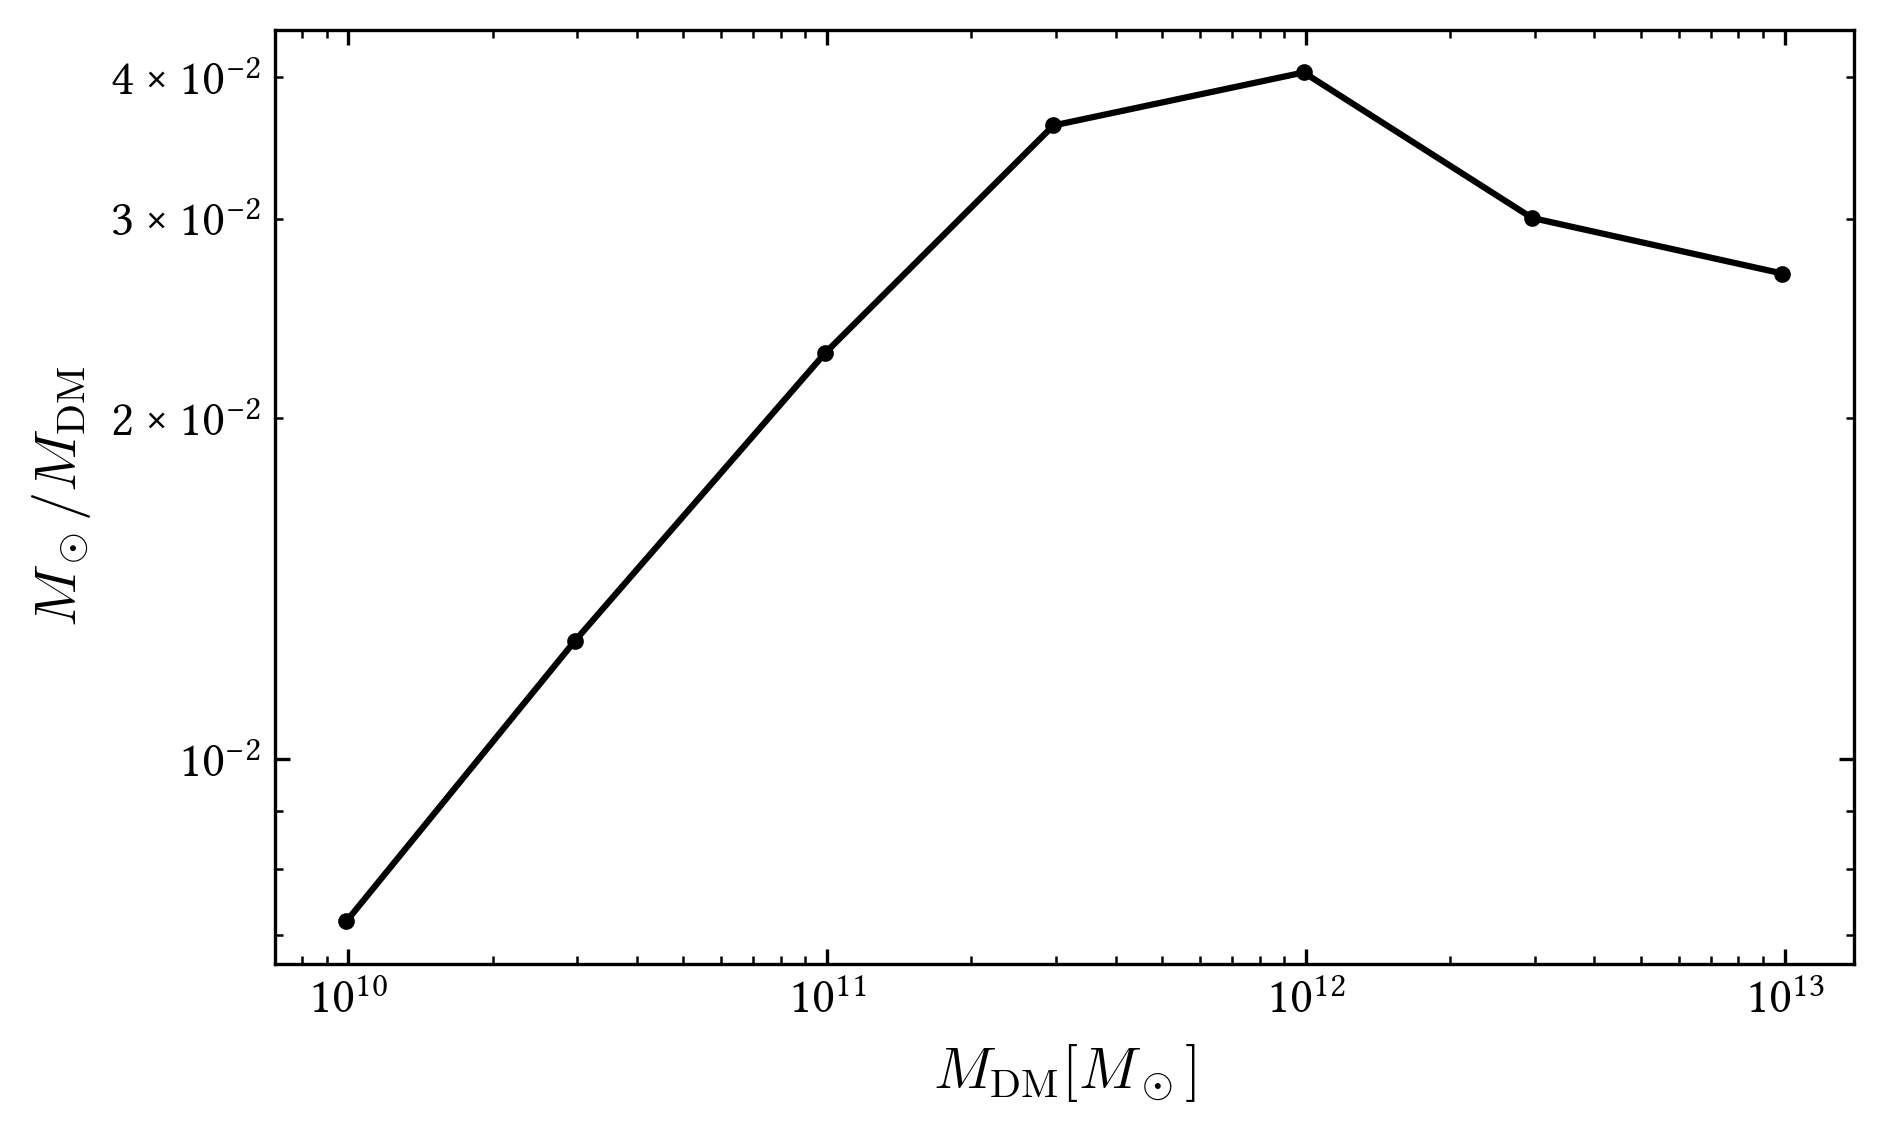

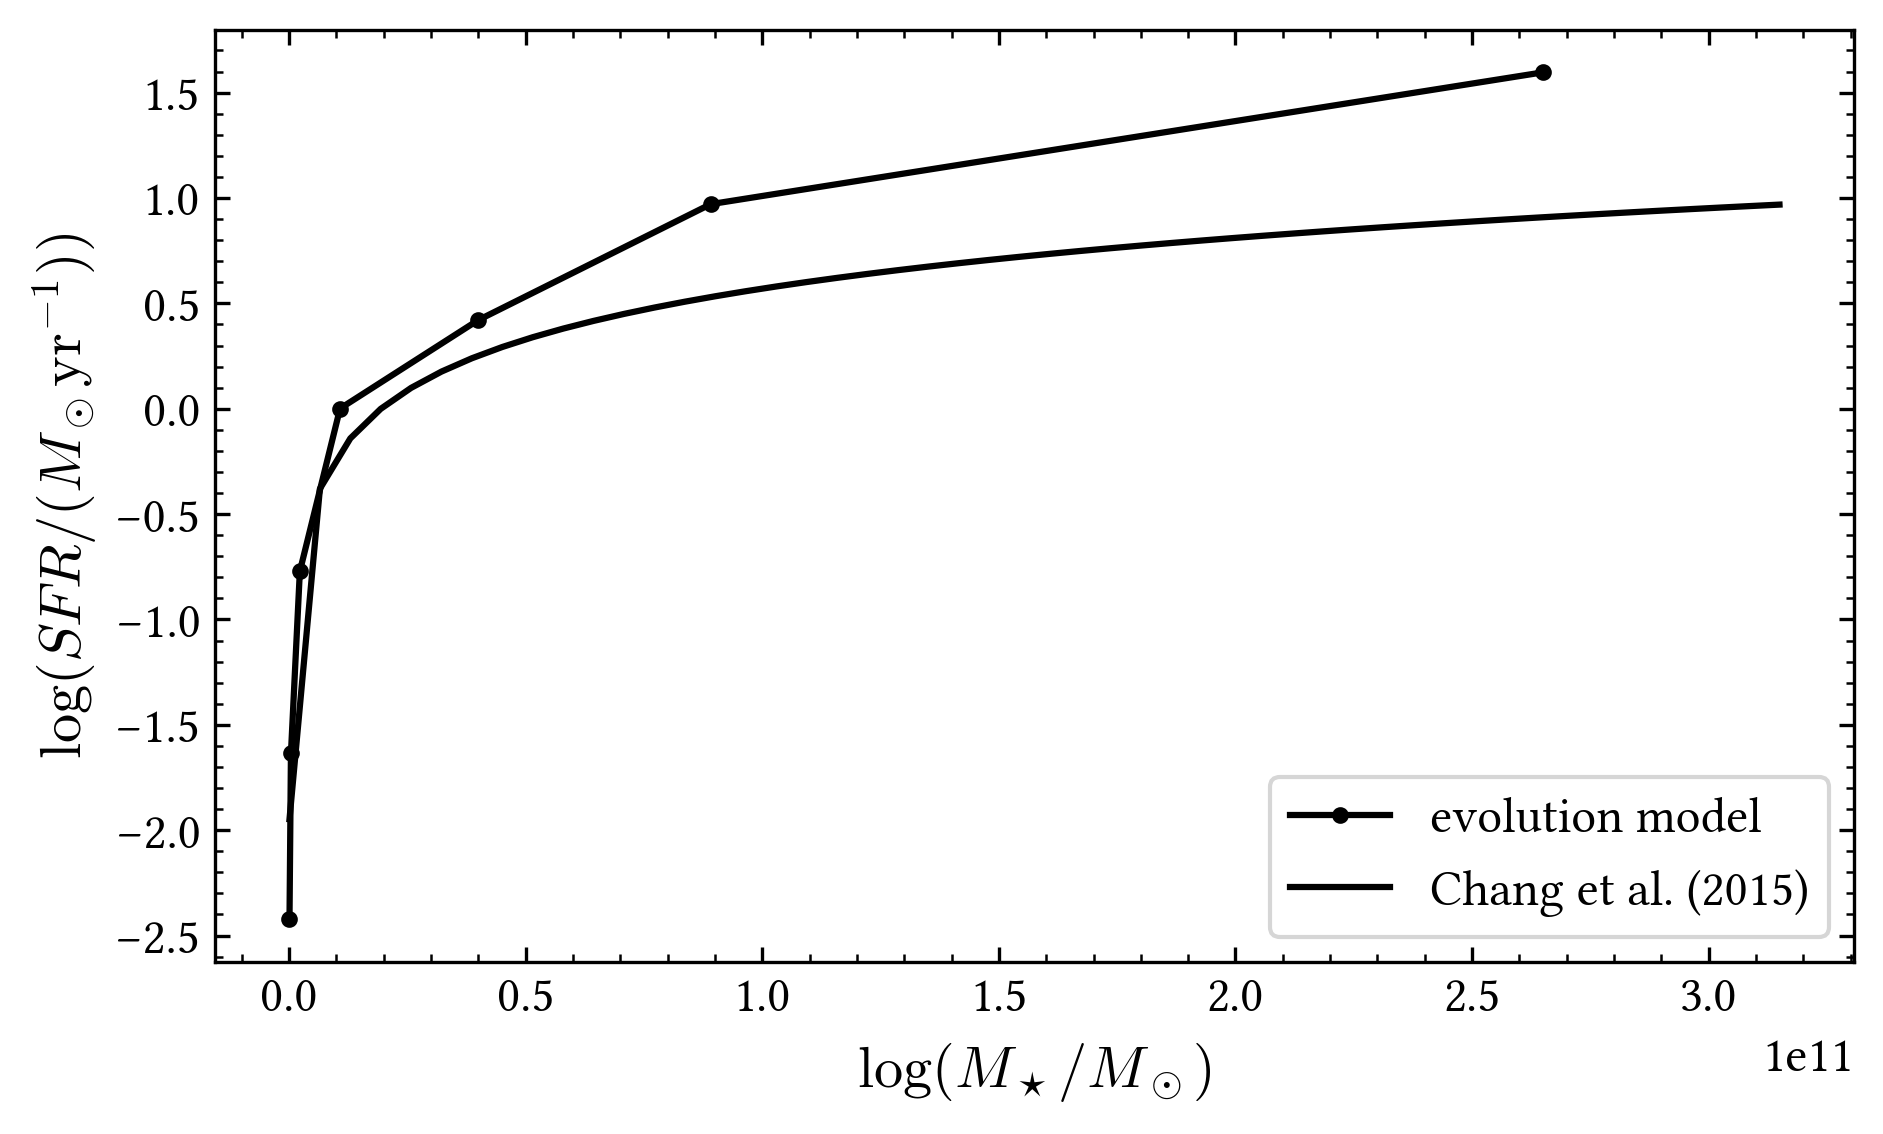

In [17]:
M_dm_list = []
SM_list = []
SFR_list = []
M_g_list = []

for M_vir, df in data.items():
            _, M_dm, M_g, M_star, SFR = mass_evolution_v2(M_vir, df, alpha=alpha_best_lelli, beta=beta_best_lelli)
            M_dm_list.append(M_dm[-1])
            M_g_list.append(M_g[-1])
            SM_list.append(M_star[-1])
            SFR_list.append(SFR[-1])

M_dm_list = np.array(M_dm_list)
M_g_list = np.array(M_g_list)
SM_list = np.array(SM_list)
SFR_list = np.array(SFR_list)
ratio = SM_list/M_dm_list

fig, ax = plt.subplots(figsize=fsize_large)
if print_titles: fig.suptitle(r'Stellar Mass to Dark Matter Ratio with with $\chi^2$-Optimization')

ax.loglog(M_dm_list, ratio, marker='.')
ax.set_xlabel(r'$M_{\text{DM}} [M_\odot]$')
ax.set_ylabel(r'$M_\odot / M_{\text{DM}}$')
plt.tight_layout()

if save_figures: plt.savefig('plots/SM-DM_opt_chi.pdf')
plt.show()
plt.close()

# SFR over SM Plot

SM_range = np.linspace(SM_list[0], SM_list[-1]+5e10)
results_chang = sfr_chang(SM_range)

fig, ax = plt.subplots(figsize=fsize_large)
if print_titles: fig.suptitle(r'Star Formation Rate Comparison with $\chi^2$-Optimization')

ax.plot(SM_list,np.log10(SFR_list),marker='.', label='evolution model')
ax.plot(SM_range, results_chang, label='Chang et al. (2015)')

ax.set_xlabel(r'$\log(M_\star / M_\odot)$')
ax.set_ylabel(r'$\log(SFR / (M_\odot \text{yr}^{-1}))$')
plt.legend()
plt.tight_layout()

if save_figures: plt.savefig('plots/SFR_comparison_chi.pdf')

# Dump

Code that was written but not used, just in case we need to recycle it.

1. `get_initial_mass()` function to get the initial values for M_dm, M_g, M_star. However, it turns out to get better restults by starting with 0,0,0

In [18]:
def get_initial_mass(M_vir, df, f_b=0.18, stellar_frac=0.09):
    '''
    Gets the initials masses at t_c = 0 for dm, gas and stars

    INPUT
    -----
    M_vir : (float)
    df    : (pd.DataFrame)
    dm_ratio, stellar_ratio : (float)

    OUTPUT
    -----
    M_dm, M_g, M_star : (float)
    '''

    dm_frac = 1.0 - f_b
    dm_frac = 1    # Assuming M_dm = M_vir for z = 0 offers good results (something is wrong)
    
    # Extract the data
    t_c   = df['t_c']
    dM_dm = df['MAR']
    M0_dm = dm_frac * 10**M_vir              # Dark matter mass at z=0

    area = 0                                 # This will be our integral
    # print(f"At z=0: M_dm = {M0_dm:.3f}")

    for i in range(len(t_c) - 1):
        area += (t_c[i+1] - t_c[i]) * 1e9 * dM_dm[i]   # delta t [Gyr] * 1e9 * delta M [solar masses/yr]
    # print(f'Area: {area:.3}')

    M_dm = M0_dm + area                      # Dark matter mass t_c=0. Area is negative since we are going backwards in time
    # print(f"At t=0: M_dm = {M_dm:.3}")
    
    # Calculating stellar mass and gas mass from ratio to dm
    dm_frac   = 1.0 - f_b
    gas_ratio = 1 - dm_frac - stellar_frac 
    M_star    = M_dm * stellar_frac/dm_frac  # Stellar mass
    M_g       = M_dm * gas_ratio/dm_frac     # Gas mass t=0

    return M_dm, M_g, M_star

print(get_initial_mass(10,data[10]))


(np.float64(86655018.8999958), np.float64(9510916.708536118), np.float64(9510916.708536124))


# To Do
*Maybe* try runge kutta just as a comparison.
